# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from math import ceil

In [3]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz
from scipy.sparse import coo_matrix

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Data

In [4]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [5]:
data.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


# EDA

In [6]:
REVIEW = 'Review Text'
CLASS = 'Rating'

**Stopwords** 
```
Add more stopwords to the list after EDA, words common to all rating classes
```

In [7]:
with open('stopwords.txt') as f:
    stopwords_ = f.readlines()

In [8]:
stopwords = (set(map(lambda x: x.strip(), stopwords_))-set(['neither', 'no', 'not', 'nor', 'none', 'never']))|set(['.', 
            'dress', 'not', 'like', 'size', 'fabric', 'fit'])

In [ ]:
print(sorted(stopwords))

['.', 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldn', "couldn't", 'couldnt', 'cry', 'd', 'de', 'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'done', 'down', 'dress', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'fabric', 'few'

**Cleaning**

In [ ]:
def remove_stop_words(X):
    features = []
    for x in X.split():
        if x.lower() not in stopwords:
            features.append(x.lower())
    return ' '.join(features)

In [ ]:
data[REVIEW] = data[REVIEW].apply(lambda x : re.sub(r'\.', ' . ', str(x)))
data[REVIEW] = data[REVIEW].apply(lambda x : re.sub(r'\s+', ' ', str(x)))

In [ ]:
reviews = data[REVIEW].apply(lambda x : re.sub(r'\W', ' ', str(x)))
reviews = reviews.apply(lambda x : re.sub(r'\d', ' ', str(x)))
reviews = reviews.apply(lambda x : re.sub(r'\.', ' . ', str(x)))
reviews = reviews.apply(lambda x : re.sub(r'\s+', ' ', str(x)))
reviews = reviews.apply(lambda x : x.strip())
reviews = reviews.apply(remove_stop_words)

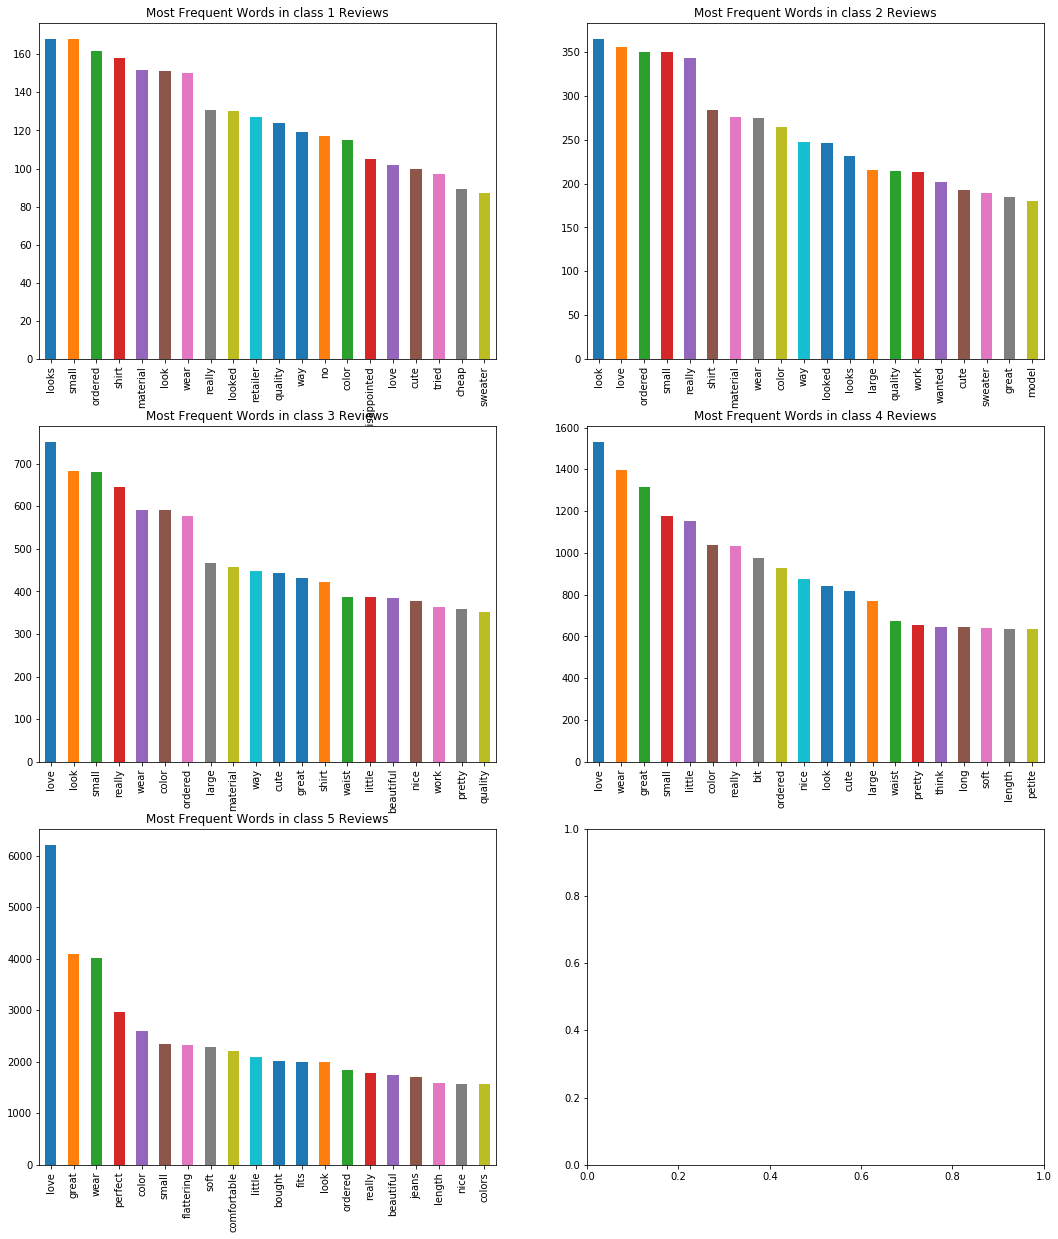

In [ ]:
classes = sorted(data[CLASS].unique())
fig, ax = plt.subplots(figsize=(18,int(7*ceil(len(classes)/2))), nrows=ceil(len(classes)/2), ncols=2)
for i, c in enumerate(classes):
    pd.Series(' '.join(reviews[data[CLASS]==c]).lower().split()).value_counts()[:20].plot.bar(ax = ax[i//2][i%2])
    ax[i//2][i%2].set_title(f'Most Frequent Words in class {c} Reviews')

# Insights

In [ ]:
def reduce_pos(x):
    tags = pos_tag(word_tokenize(x.lower()))
    words = []
    for t in tags:
        if t[1] in ['FW', 'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS']:
            words.append(t[0])
    return ' '.join(words)

def indices_for_rating(rating):
    indices = []
    for i in range(len(reviews)):
        if data.iloc[i][CLASS]==rating:
            indices.append(i)
    return indices

def check_duplicacy(keyword, results):
    fuzz_sim = 0
    for k in results:
        fuzz_sim = max(fuzz.token_set_ratio(k, keyword), fuzz_sim)
    return 1 if fuzz_sim >= 80 else 0

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=3):
    score_vals = []
    feature_vals = []
    
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
        
    results= []
    for idx in range(len(feature_vals)):
        if check_duplicacy(feature_vals[idx], results) == 0:
            results.append(feature_vals[idx])
        if len(results) == topn:
            break
    
    return results

def extract_keywords(index, k, vectorizer):
    feature_names=vectorizer.get_feature_names()
    doc=reviews[index]
    tf_idf_vector=vectorizer.transform([doc])
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,k)
    return keywords

flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
droplist = stopwords|set()

In [ ]:
def relations(tags, kws):
    insights = []
    for i in range(len(tags)):
        if tags[i][0] in kws and tags[i][1] in ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS']:
            if tags[i][1] in ['JJ', 'JJR', 'JJS']:
                # Adjective -> search for nearest noun (after)
                # after
                j = i
                while j < len(tags):
                    if tags[j][1] in ['NN', 'NNS', 'NNP', 'NNPS'] and re.match(r'\w+', tags[j][0]) and tags[j][0] not in droplist:
                        insights.append(tags[i][0]+' '+tags[j][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j += 1
                # before
                j = i
                while j > 0:
                    if tags[j][1] in ['NN', 'NNS', 'NNP', 'NNPS'] and re.match(r'\w+', tags[j][0]) and tags[j][0] not in droplist:
                        insights.append(tags[j][0]+' '+tags[i][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j -= 1
            elif tags[i][1] in ['RB', 'RBR', 'RBS']:
                # Adjverb -> search for nearest verb (before)
                 # after
                j = i
                while j < len(tags):
                    if tags[j][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] and re.match(r'\w+', tags[j][0]) and tags[j][0] not in droplist:
                        insights.append(tags[i][0]+' '+tags[j][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j += 1
                # before
                j = i
                while j > 0:
                    if tags[j][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] and re.match(r'\w+', tags[j][0]) and tags[j][0] not in droplist:
                        insights.append(tags[j][0]+' '+tags[i][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j -= 1
            else:
                # noun -> search for nearest adjective (before)
                # after
                j = i
                while j < len(tags):
                    if tags[j][1] in ['JJ', 'JJR', 'JJS'] and re.match(r'\w+', tags[j][0]) and tags[j][0] not in droplist:
                        insights.append(tags[i][0]+' '+tags[j][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j += 1
                # before
                j = i
                while j > 0:
                    if tags[j][1] in ['JJ', 'JJR', 'JJS'] and re.match(r'\w+', tags[j][0]) and tags[j][0] not in droplist:
                        insights.append(tags[j][0]+' '+tags[i][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j -= 1
    return insights

In [ ]:
domain_specific_stopwords = []
reduced_reviews = reviews.apply(reduce_pos)
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(reduced_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [ ]:
query = 1

keywords = []
for i in indices_for_rating(query):
    keywords += extract_keywords(i, 3, vectorizer)

kws = flatten(list(map(lambda x : x.split(), keywords)))
kws= pd.Series(kws).value_counts().index.tolist()
kws = [k for k in kws if k not in ['neither', 'no', 'not', 'nor', 'none', 'never']]
kws = kws[:25]

insights = []
for i in indices_for_rating(query):
    tags = pos_tag(word_tokenize(data[REVIEW][i].lower()))
    insights += relations(tags, kws)

insights = pd.DataFrame(pd.Series(insights).value_counts())
insights.reset_index(inplace=True)
insights.columns = ['Insight', 'Counts']

rows2drop = []
for i in range(len(insights)):
    for j in range(i+1, len(insights)):
        if fuzz.token_set_ratio(insights['Insight'][i], insights['Insight'][j]) == 100:
            insights['Counts'][i] += insights['Counts'][j]
            rows2drop.append(j)
    for sw in domain_specific_stopwords:
        if sw in insights['Insight'][i]:
            rows2drop.append(i)
            break
insights.drop(rows2drop, inplace=True)
insights.sort_values(by='Counts', inplace=True, ascending=False)
insights.reset_index(drop=True, inplace=True)

ax = insights.iloc[::-1].tail(25).plot.barh(x='Insight', y='Counts', figsize=(18,8),fontsize=12, title=f'Customer focus areas for {query} rated reviews')
ax.title.set_size(25)

In [ ]:
query = 2

keywords = []
for i in indices_for_rating(query):
    keywords += extract_keywords(i, 3, vectorizer)

kws = flatten(list(map(lambda x : x.split(), keywords)))
kws= pd.Series(kws).value_counts().index.tolist()
kws = [k for k in kws if k not in ['neither', 'no', 'not', 'nor', 'none', 'never']]
kws = kws[:25]

insights = []
for i in indices_for_rating(query):
    tags = pos_tag(word_tokenize(data[REVIEW][i].lower()))
    insights += relations(tags, kws)

insights = pd.DataFrame(pd.Series(insights).value_counts())
insights.reset_index(inplace=True)
insights.columns = ['Insight', 'Counts']

rows2drop = []
for i in range(len(insights)):
    for j in range(i+1, len(insights)):
        if fuzz.token_set_ratio(insights['Insight'][i], insights['Insight'][j]) == 100:
            insights['Counts'][i] += insights['Counts'][j]
            rows2drop.append(j)
    for sw in domain_specific_stopwords:
        if sw in insights['Insight'][i]:
            rows2drop.append(i)
            break
insights.drop(rows2drop, inplace=True)
insights.sort_values(by='Counts', inplace=True, ascending=False)
insights.reset_index(drop=True, inplace=True)

ax = insights.iloc[::-1].tail(25).plot.barh(x='Insight', y='Counts', figsize=(18,8),fontsize=12, title=f'Customer focus areas for {query} rated reviews')
ax.title.set_size(25)

In [ ]:
query = 3

keywords = []
for i in indices_for_rating(query):
    keywords += extract_keywords(i, 3, vectorizer)

kws = flatten(list(map(lambda x : x.split(), keywords)))
kws= pd.Series(kws).value_counts().index.tolist()
kws = [k for k in kws if k not in ['neither', 'no', 'not', 'nor', 'none', 'never']]
kws = kws[:25]

insights = []
for i in indices_for_rating(query):
    tags = pos_tag(word_tokenize(data[REVIEW][i].lower()))
    insights += relations(tags, kws)

insights = pd.DataFrame(pd.Series(insights).value_counts())
insights.reset_index(inplace=True)
insights.columns = ['Insight', 'Counts']

rows2drop = []
for i in range(len(insights)):
    for j in range(i+1, len(insights)):
        if fuzz.token_set_ratio(insights['Insight'][i], insights['Insight'][j]) == 100:
            insights['Counts'][i] += insights['Counts'][j]
            rows2drop.append(j)
    for sw in domain_specific_stopwords:
        if sw in insights['Insight'][i]:
            rows2drop.append(i)
            break
insights.drop(rows2drop, inplace=True)
insights.sort_values(by='Counts', inplace=True, ascending=False)
insights.reset_index(drop=True, inplace=True)

ax = insights.iloc[::-1].tail(25).plot.barh(x='Insight', y='Counts', figsize=(18,8),fontsize=12, title=f'Customer focus areas for {query} rated reviews')
ax.title.set_size(25)

In [ ]:
query = 4

keywords = []
for i in indices_for_rating(query):
    keywords += extract_keywords(i, 3, vectorizer)

kws = flatten(list(map(lambda x : x.split(), keywords)))
kws= pd.Series(kws).value_counts().index.tolist()
kws = [k for k in kws if k not in ['neither', 'no', 'not', 'nor', 'none', 'never']]
kws = kws[:25]

insights = []
for i in indices_for_rating(query):
    tags = pos_tag(word_tokenize(data[REVIEW][i].lower()))
    insights += relations(tags, kws)

insights = pd.DataFrame(pd.Series(insights).value_counts())
insights.reset_index(inplace=True)
insights.columns = ['Insight', 'Counts']

rows2drop = []
for i in range(len(insights)):
    for j in range(i+1, len(insights)):
        if fuzz.token_set_ratio(insights['Insight'][i], insights['Insight'][j]) == 100:
            insights['Counts'][i] += insights['Counts'][j]
            rows2drop.append(j)
    for sw in domain_specific_stopwords:
        if sw in insights['Insight'][i]:
            rows2drop.append(i)
            break
insights.drop(rows2drop, inplace=True)
insights.sort_values(by='Counts', inplace=True, ascending=False)
insights.reset_index(drop=True, inplace=True)

ax = insights.iloc[::-1].tail(25).plot.barh(x='Insight', y='Counts', figsize=(18,8),fontsize=12, title=f'Customer focus areas for {query} rated reviews')
ax.title.set_size(25)

In [ ]:
query = 5

keywords = []
for i in indices_for_rating(query):
    keywords += extract_keywords(i, 3, vectorizer)

kws = flatten(list(map(lambda x : x.split(), keywords)))
kws= pd.Series(kws).value_counts().index.tolist()
kws = [k for k in kws if k not in ['neither', 'no', 'not', 'nor', 'none', 'never']]
kws = kws[:25]

insights = []
for i in indices_for_rating(query):
    tags = pos_tag(word_tokenize(data[REVIEW][i].lower()))
    insights += relations(tags, kws)

insights = pd.DataFrame(pd.Series(insights).value_counts())
insights.reset_index(inplace=True)
insights.columns = ['Insight', 'Counts']

rows2drop = []
for i in range(len(insights)):
    for j in range(i+1, len(insights)):
        if fuzz.token_set_ratio(insights['Insight'][i], insights['Insight'][j]) == 100:
            insights['Counts'][i] += insights['Counts'][j]
            rows2drop.append(j)
    for sw in domain_specific_stopwords:
        if sw in insights['Insight'][i]:
            rows2drop.append(i)
            break
insights.drop(rows2drop, inplace=True)
insights.sort_values(by='Counts', inplace=True, ascending=False)
insights.reset_index(drop=True, inplace=True)

ax = insights.iloc[::-1].tail(25).plot.barh(x='Insight', y='Counts', figsize=(18,8),fontsize=12, title=f'Customer focus areas for {query} rated reviews')
ax.title.set_size(25)